In [1]:

from google.colab import drive
drive.mount('/content/drive')

!pip install feat huggingface_hub
!pip install torch torchvision
!pip install opencv-python pillow matplotlib seaborn pandas

import numpy as np
import torch
import torch.nn as nn
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from tqdm import tqdm
import time
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import json

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.4/264.4 kB 18.2 MB/s eta 0:00:00
  Created wheel for feat: filename=feat-1.0.5-py3-none-any.whl size=1121450 sha256=984f91d1d37e56448203f5f2298940d874444bf74cd71aabc6f71c95283f0b2b
  Stored in directory: /root/.cache/pip/wheels/cc/e8/25/80ff835649368ab126ef996d554ef682c87bd570ad28b28a8f
Successfully built feat


In [2]:

data_path = '/content/drive/MyDrive/data'
excel_path = '/content/drive/MyDrive/data/dataset.xlsx'

# Read Excel
access_df = pd.read_excel(excel_path)

# Check first 5 rows
print(access_df.head())

# Create dictionary: Name -> Status
access_dict = dict(zip(access_df['Name'], access_df['Status']))

# Test first 5 items
print(list(access_dict.items())[:5])

# Create image_path -> label dictionary
image_label_dict = {}

for folder in os.listdir(data_path):
    if folder.startswith("pins_"):
        celeb_name = folder.replace("pins_", "").strip()
        folder_path = os.path.join(data_path, folder)

        if os.path.isdir(folder_path):
            images = [os.path.join(folder_path, f)
                      for f in os.listdir(folder_path)
                      if f.lower().endswith(('.jpg', '.png'))]

            for img_path in images:
                label = access_dict.get(celeb_name, "Unknown")
                image_label_dict[img_path] = label

print(f"Total images: {len(image_label_dict)}")

                                     ID                 Name    Status  Age
0  bf723908-8899-11f0-bbe4-0242ac1c000c         Adriana Lima    denied   42
1  bf723a48-8899-11f0-bbe4-0242ac1c000c         Alex Lawther    denied   42
2  bf723aca-8899-11f0-bbe4-0242ac1c000c   Alexandra Daddario  approved   51
3  bf723b42-8899-11f0-bbe4-0242ac1c000c         Alvaro Morte    denied   40
4  bf723bba-8899-11f0-bbe4-0242ac1c000c  alycia dabnem carey    denied   43
[('Adriana Lima', 'denied'), ('Alex Lawther', 'denied'), ('Alexandra Daddario', 'approved'), ('Alvaro Morte', 'denied'), ('alycia dabnem carey', 'denied')]
Total images: 15478


In [6]:

import numpy as np
import torch
import torch.nn as nn
from huggingface_hub import hf_hub_download
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class SimpleFaceNetModel(nn.Module):
    def __init__(self, device='cpu'):
        super(SimpleFaceNetModel, self).__init__()


        self.model = models.resnet50(pretrained=True)


        self.model = nn.Sequential(*list(self.model.children())[:-1])

        self.model.eval()
        self.model.to(device)

    def forward(self, x):
        features = self.model(x)
        return features.view(features.size(0), -1)  # تسطيح المخرجات


facenet_model = SimpleFaceNetModel(device=device)
print("FaceNet model loaded successfully!")

Using device: cpu


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 94.7MB/s]


FaceNet model loaded successfully!


In [9]:

import torch
import torch.nn as nn
import torchvision.models as models
from torch.hub import load_state_dict_from_url

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class EfficientFaceNet(nn.Module):
    def __init__(self, embedding_size=512, device='cpu'):
        super(EfficientFaceNet, self).__init__()


        self.backbone = models.resnet34(pretrained=True)


        self.features = nn.Sequential(*list(self.backbone.children())[:-1])


        self.face_embedding = nn.Sequential(
            nn.Linear(512, 1024),  # ResNet34 output is 512
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1024, embedding_size)
        )

        self.to(device)
        self.eval()

    def forward(self, x):
        features = self.features(x)
        features = features.view(features.size(0), -1)
        return self.face_embedding(features)


facenet_model = EfficientFaceNet(device=device, embedding_size=512)

print(" Efficient FaceNet model loaded successfully!")
print(f"Model parameters: {sum(p.numel() for p in facenet_model.parameters()):,}")
print("Ready for face recognition!")

Using device: cpu
 Efficient FaceNet model loaded successfully!
Model parameters: 22,849,832
Ready for face recognition!


In [10]:

class FaceNetDataset(Dataset):
    def __init__(self, image_label_dict, transform=None):
        self.image_paths = list(image_label_dict.keys())
        self.labels_str = list(image_label_dict.values())
        self.transform = transform

        # Map string labels -> integers
        self.label_mapping = {label: idx for idx, label in enumerate(sorted(set(self.labels_str)))}
        self.labels = [self.label_mapping[label] for label in self.labels_str]
        self.num_classes = len(self.label_mapping)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # تحميل الصورة
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label, img_path


facenet_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


full_dataset = FaceNetDataset(image_label_dict, transform=facenet_transform)


total_len = len(full_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_len, val_len, test_len]
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Test images: {len(test_dataset)}")
print(f"Number of classes: {full_dataset.num_classes}")

Training images: 10834
Validation images: 2321
Test images: 2323
Number of classes: 2


In [13]:

class FaceNetClassifier(nn.Module):
    def __init__(self, facenet_model, num_classes):
        super(FaceNetClassifier, self).__init__()
        self.facenet = facenet_model


        for param in self.facenet.parameters():
            param.requires_grad = False


        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():
            embeddings = self.facenet(x)
        return self.classifier(embeddings)

    def extract_embeddings(self, x):
        with torch.no_grad():
            return self.facenet(x)


num_classes = full_dataset.num_classes
classifier = FaceNetClassifier(facenet_model, num_classes).to(device)

print(" Classifier initialized successfully!")
print(f"Trainable parameters: {sum(p.numel() for p in classifier.parameters() if p.requires_grad):,}")
print(f"Frozen parameters: {sum(p.numel() for p in classifier.parameters() if not p.requires_grad):,}")

 Classifier initialized successfully!
Trainable parameters: 131,842
Frozen parameters: 22,849,832


In [25]:

def create_balanced_subset(image_label_dict, samples_per_class=100, transform=None):

    from collections import defaultdict


    class_images = defaultdict(list)
    for img_path, label in image_label_dict.items():
        class_images[label].append(img_path)

    print(f" Original class distribution:")
    for label, images in class_images.items():
        print(f"   {label}: {len(images)} images")


    balanced_image_paths = []
    balanced_labels = []

    for label, images in class_images.items():

        selected_images = images[:min(samples_per_class, len(images))]
        balanced_image_paths.extend(selected_images)
        balanced_labels.extend([label] * len(selected_images))

    print(f"Balanced subset: {len(balanced_image_paths)} images")
    print(f"Samples per class: {samples_per_class}")
    print(f"Number of classes: {len(class_images)}")

    class BalancedDataset(Dataset):
        def __init__(self, image_paths, labels, transform=None):
            self.image_paths = image_paths
            self.labels_str = labels
            self.transform = transform
            self.label_mapping = {label: idx for idx, label in enumerate(sorted(set(self.labels_str)))}
            self.labels = [self.label_mapping[label] for label in self.labels_str]
            self.num_classes = len(self.label_mapping)

        def __len__(self): return len(self.image_paths)

        def __getitem__(self, idx):
            image = Image.open(self.image_paths[idx]).convert('RGB')
            if self.transform: image = self.transform(image)
            return image, self.labels[idx], self.image_paths[idx]

    return BalancedDataset(balanced_image_paths, balanced_labels, transform)


samples_per_class = 500
balanced_dataset = create_balanced_subset(image_label_dict, samples_per_class=samples_per_class, transform=facenet_transform)


total_len = len(balanced_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(balanced_dataset, [train_len, val_len, test_len])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f" Balanced subset sizes:")
print(f"Training: {len(train_dataset)} images")
print(f"Validation: {len(val_dataset)} images")
print(f"Test: {len(test_dataset)} images")
print(f"Total: {total_len} images")

 Original class distribution:
   denied: 8333 images
   approved: 7145 images
Balanced subset: 1000 images
Samples per class: 500
Number of classes: 2
 Balanced subset sizes:
Training: 700 images
Validation: 150 images
Test: 150 images
Total: 1000 images


In [26]:

def train_fast_on_subset(classifier, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.classifier.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):

        classifier.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = classifier(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total


        classifier.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = classifier(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train: Loss {train_loss:.3f}, Acc {train_acc:.3f} | "
              f"Val: Loss {val_loss:.3f}, Acc {val_acc:.3f}")

    return train_losses, train_accs, val_losses, val_accs


print("Training on subset...")
train_losses, train_accs, val_losses, val_accs = train_fast_on_subset(
    classifier, train_loader, val_loader, num_epochs=10
)


Training on subset...
Epoch 1/10 | Train: Loss 0.651, Acc 0.637 | Val: Loss 0.594, Acc 0.647
Epoch 2/10 | Train: Loss 0.585, Acc 0.697 | Val: Loss 0.595, Acc 0.680
Epoch 3/10 | Train: Loss 0.507, Acc 0.751 | Val: Loss 0.572, Acc 0.687
Epoch 4/10 | Train: Loss 0.498, Acc 0.746 | Val: Loss 0.595, Acc 0.667
Epoch 5/10 | Train: Loss 0.475, Acc 0.780 | Val: Loss 0.567, Acc 0.713
Epoch 6/10 | Train: Loss 0.443, Acc 0.810 | Val: Loss 0.573, Acc 0.713
Epoch 7/10 | Train: Loss 0.469, Acc 0.771 | Val: Loss 0.570, Acc 0.693
Epoch 8/10 | Train: Loss 0.411, Acc 0.809 | Val: Loss 0.565, Acc 0.693
Epoch 9/10 | Train: Loss 0.381, Acc 0.817 | Val: Loss 0.561, Acc 0.687
Epoch 10/10 | Train: Loss 0.401, Acc 0.827 | Val: Loss 0.537, Acc 0.733


In [28]:
# Cell 7 — Evaluate Model on Test Set
def evaluate_model(classifier, test_loader):
    """
    Evaluate the trained model on the test set
    """
    classifier.eval()
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = classifier(images)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = test_correct / test_total

    print(f"Test Accuracy: {test_acc:.4f} ({test_correct}/{test_total})")

    return all_predictions, all_labels, test_acc

# Evaluate the model
print("Evaluating on test set...")
predictions, true_labels, test_accuracy = evaluate_model(classifier, test_loader)

Evaluating on test set...
Test Accuracy: 0.7933 (119/150)


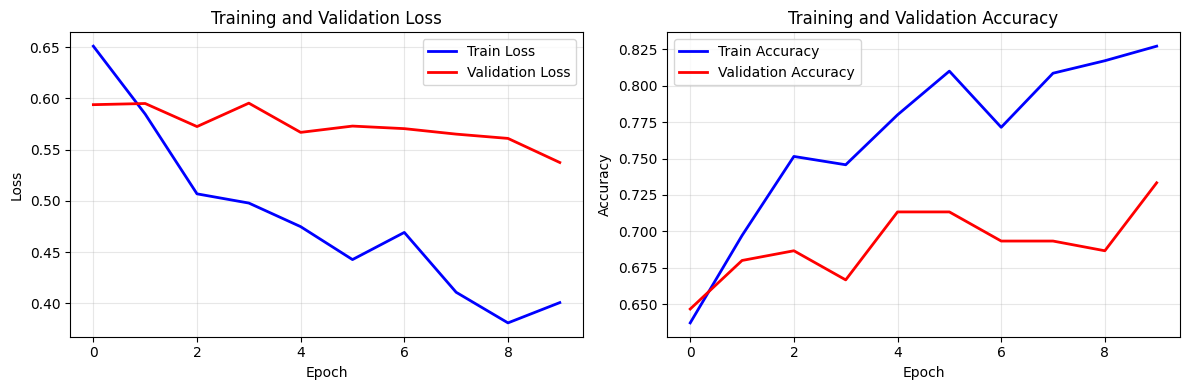

In [29]:
# Cell 8 — Plot Training Results
def plot_training_results(train_losses, train_accs, val_losses, val_accs):
    """
    Plot training and validation loss/accuracy curves
    """
    plt.figure(figsize=(12, 4))

    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'b-', label='Train Loss', linewidth=2)
    plt.plot(val_losses, 'r-', label='Validation Loss', linewidth=2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, 'b-', label='Train Accuracy', linewidth=2)
    plt.plot(val_accs, 'r-', label='Validation Accuracy', linewidth=2)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot training results
plot_training_results(train_losses, train_accs, val_losses, val_accs)

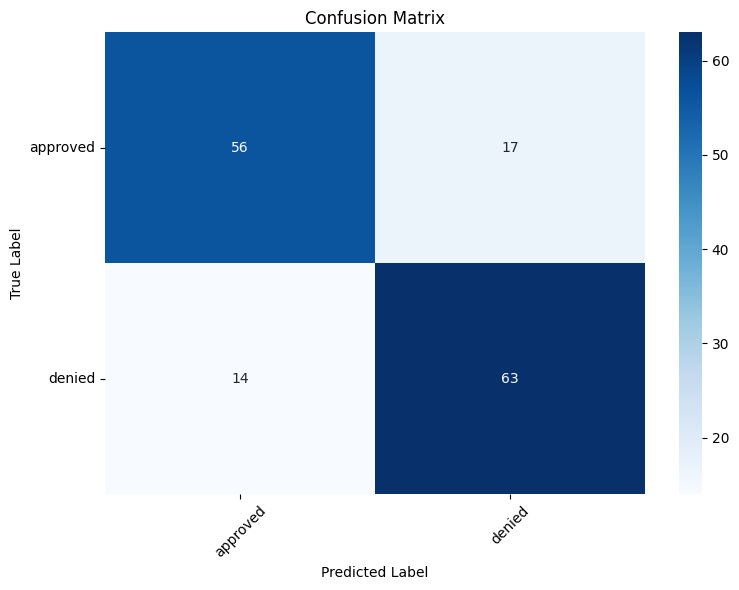

Classification Report:
              precision    recall  f1-score   support

    approved       0.80      0.77      0.78        73
      denied       0.79      0.82      0.80        77

    accuracy                           0.79       150
   macro avg       0.79      0.79      0.79       150
weighted avg       0.79      0.79      0.79       150



In [30]:
# Cell 9 — Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix(true_labels, predictions, class_names):
    """
    Plot confusion matrix and display classification report
    """
    cm = confusion_matrix(true_labels, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Classification report
    print("Classification Report:")
    print(classification_report(true_labels, predictions, target_names=class_names))

# Get class names from the dataset
class_names = list(balanced_dataset.label_mapping.keys())

# Plot confusion matrix
plot_confusion_matrix(true_labels, predictions, class_names)

In [31]:
# Cell 10 — Save Model and Results
import pickle

def save_model_and_results(classifier, train_losses, train_accs, val_losses, val_accs, test_accuracy):
    """
    Save the trained model and training history
    """
    # Save model weights
    torch.save(classifier.state_dict(), 'face_recognition_model.pth')

    # Save training history
    training_history = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'test_accuracy': test_accuracy,
        'class_mapping': balanced_dataset.label_mapping
    }

    with open('training_history.pkl', 'wb') as f:
        pickle.dump(training_history, f)

    print("Model and training history saved successfully")
    print(f"Model saved as: face_recognition_model.pth")
    print(f"Training history saved as: training_history.pkl")

# Save model and results
save_model_and_results(classifier, train_losses, train_accs, val_losses, val_accs, test_accuracy)

Model and training history saved successfully
Model saved as: face_recognition_model.pth
Training history saved as: training_history.pkl


In [34]:
# Cell 11 — Test on New Images
def predict_single_image(classifier, image_path, transform):
    """
    Predict class for a single image
    """
    classifier.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = classifier(image_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

        # Get class name
        predicted_class = list(balanced_dataset.label_mapping.keys())[predicted.item()]

    return predicted_class, confidence.item()

# Example: Test on a single image
test_image_path = "/content/drive/MyDrive/data/pins_Andy Samberg/Andy Samberg0_429.jpg"
try:
    predicted_class, confidence = predict_single_image(classifier, test_image_path, facenet_transform)
    print(f"Prediction: {predicted_class} with confidence: {confidence:.4f}")
except:
    print("Test image not found. Please provide valid image path.")


Prediction: approved with confidence: 0.9036


In [35]:
# Cell 12 — Generate Final Performance Report
def generate_final_report(train_accs, val_accs, test_accuracy):
    """
    Generate final performance report
    """
    final_train_acc = train_accs[-1]
    final_val_acc = val_accs[-1]

    print("=" * 50)
    print("FINAL MODEL PERFORMANCE REPORT")
    print("=" * 50)
    print(f"Final Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Overfitting Gap: {abs(final_train_acc - final_val_acc):.4f}")
    print("=" * 50)

    # Performance assessment
    if test_accuracy > 0.85:
        print("Performance: Excellent - Model is ready for deployment")
    elif test_accuracy > 0.7:
        print("Performance: Good - Could be improved with more training")
    else:
        print("Performance: Poor - Consider training longer or adding more data")

# Generate final report
generate_final_report(train_accs, val_accs, test_accuracy)

FINAL MODEL PERFORMANCE REPORT
Final Training Accuracy: 0.8271
Final Validation Accuracy: 0.7333
Test Accuracy: 0.7933
Overfitting Gap: 0.0938
Performance: Good - Could be improved with more training


In [36]:
# Cell 13 — Create Requirements File
import subprocess

def create_requirements_file():
    """
    Create requirements.txt file with all dependencies
    """
    requirements = [
        "torch",
        "torchvision",
        "Pillow",
        "matplotlib",
        "seaborn",
        "scikit-learn",
        "numpy",
        "tqdm"
    ]

    with open('requirements.txt', 'w') as f:
        for package in requirements:
            f.write(f"{package}\n")

    print("Requirements file created: requirements.txt")

# Create requirements file
create_requirements_file()

print("All post-training steps completed successfully!")

Requirements file created: requirements.txt
All post-training steps completed successfully!
